In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import copy
import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm_notebook

## 1. Reading the dataset and converting the data into dataset object

In [68]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [0]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

In [70]:
# Downloading the dataset 
train_dataset = datasets.MNIST(root='./data',train=True, transform=transform, download=True)
val_dataset = datasets.MNIST(root='./data',train=False, transform=transform, download=True)

# Making the dataset iterable for mini-batch algorithm using dataloader
batch_size = 512

batches = int(len(train_dataset) / batch_size)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle = True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle = False)

print('Number of batches',batches)

print('Total Training Examples:',len(train_dataset), ' | Total Test Examples:',len(val_dataset))
dataiter = iter(train_loader)
images,labels = dataiter.next()
print('Image Tensor size:',images.size(),'Label Tensor size:',labels.size())

Number of batches 117
Total Training Examples: 60000  | Total Test Examples: 10000
Image Tensor size: torch.Size([512, 1, 28, 28]) Label Tensor size: torch.Size([512])


In [145]:
iter_no = 0
for images,labels in train_loader:
  iter_no += 1
print(iter_no)

118


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


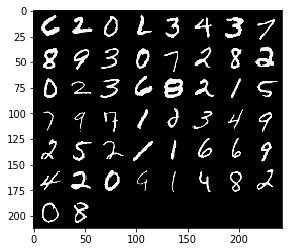

tensor([6, 2, 0, 2, 3, 4, 3, 7, 8, 9, 3, 0, 7, 2, 8, 2, 0, 2, 3, 6, 8, 2, 1, 5,
        7, 9, 7, 1, 2, 3, 4, 9, 2, 5, 2, 1, 1, 6, 6, 9, 4, 2, 0, 9, 1, 4, 8, 2,
        0, 8, 3, 6, 7, 9, 0, 0, 2, 0, 7, 5, 5, 9, 9, 2, 4, 7, 9, 2, 1, 0, 7, 5,
        5, 2, 2, 4, 6, 9, 0, 8, 7, 0, 4, 3, 0, 0, 2, 8, 1, 4, 9, 8, 8, 7, 8, 8,
        0, 9, 7, 1, 8, 2, 1, 5, 3, 0, 5, 2, 7, 0, 4, 6, 9, 3, 1, 6, 8, 9, 0, 7,
        3, 6, 4, 9, 1, 9, 1, 1, 5, 4, 9, 9, 8, 0, 6, 1, 0, 1, 1, 0, 3, 0, 1, 4,
        0, 4, 2, 0, 6, 8, 8, 0, 5, 2, 1, 2, 6, 5, 3, 9, 2, 4, 0, 0, 6, 4, 5, 6,
        5, 2, 9, 5, 3, 8, 7, 3, 2, 1, 1, 7, 2, 0, 4, 4, 7, 3, 3, 7, 2, 6, 9, 9,
        8, 8, 4, 1, 2, 4, 2, 7, 9, 1, 2, 2, 4, 0, 6, 9, 7, 8, 1, 7, 9, 5, 5, 4,
        5, 9, 5, 4, 7, 2, 4, 8, 0, 6, 8, 9, 1, 0, 1, 6, 6, 7, 3, 3, 6, 9, 1, 7,
        9, 2, 3, 1, 4, 9, 8, 2, 8, 4, 8, 1, 0, 0, 1, 9, 0, 8, 7, 1, 9, 3, 8, 4,
        5, 3, 8, 1, 3, 1, 8, 0, 2, 0, 3, 4, 9, 2, 8, 2, 1, 5, 3, 3, 7, 7, 8, 5,
        9, 6, 4, 1, 2, 6, 1, 5, 9, 0, 8,

In [71]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

def show_image(img):
    img = img.numpy()
    img = np.transpose(img,(1,2,0))
    plt.imshow(img)
    plt.show()
    
# displaying only some images from one batch
show_image(torchvision.utils.make_grid(images[0:50]))
print(labels)
print(images[0].size())

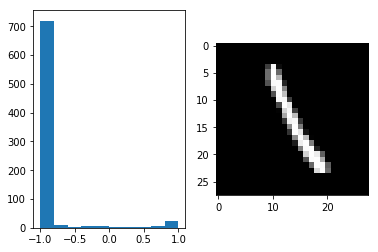

In [72]:
index = np.random.randint(batch_size)
fig, (ax1,ax2) = plt.subplots(1,2)
ax1.hist(images[index][0].numpy().reshape(-1,1))
ax2.imshow(images[index][0],cmap='Greys_r')
plt.show()

## 2. Model

In [0]:
class LeNet(nn.Module):
    
    def __init__(self):
        super(LeNet,self).__init__()
        self.conv1 = nn.Conv2d(1,6,5)
        self.maxpool = nn.MaxPool2d(2,stride=2)
        self.conv2 = nn.Conv2d(6,16,5)
        # fully connected neural network
        self.fc1 = nn.Linear(256,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)
        
    def forward(self,X):
        x = self.maxpool(F.leaky_relu(self.conv1(X)))
        x = self.maxpool(F.leaky_relu(self.conv2(x)))
        # flatten the tensors such that it can be feed forward to fully connected model
        x = x.view(x.size(0),-1)
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [0]:
def return_accuracy(dataloader,model):
    total = 0
    correct = 0
    
    for images, labels in dataloader:
        images,labels = images.to(device),labels.to(device)
        y_pred = model(images)
        total += batch_size
        correct += torch.sum((torch.argmax(y_pred,dim=1) == labels)).item()
    return correct/total*100

In [0]:
def fit(dataloader_train, model, opt, scheduler, loss_fn, epochs=15):
    
    num_batches = int(len(dataloader_train)/batch_size)+1
    
    # checkpointing
    best_accuracy = 0 
    total_accuracy = 0
    no_of_images = 0
    
    # bookkeeping
    train_accuracies = []
    val_accuracies = []
    
    train_loss_hist = []
    val_loss_hist = []
         
    for epoch in tqdm_notebook(range(epochs),unit=' Epoch', total=epochs):
        best_model = model.state_dict()       
        scheduler.step()
        
        for train_data in dataloader_train:
          no_of_images += batch_size
          # Training data
          images_train, labels_train = train_data 
          images_train, labels_train = images_train.float().to(device), labels_train.long().to(device)
          # predict the output
          train_pred = model(images_train)
          # compute the loss
          train_loss = loss_fn(train_pred,labels_train)
          # backward propagation                   
          train_loss.backward()
          # update the weights
          opt.step()
          # reset the gradients
          opt.zero_grad()
          # clear the GPU memory
          del images_train, labels_train, train_pred, 
          torch.cuda.empty_cache()

          if no_of_images % (batch_size*num_batches/2) == 0:
            ## compute the accuracy
            train_accuracy = return_accuracy(dataloader_train,model)
            train_accuracies.append(train_accuracy)
            train_loss_hist.append(train_loss.item())
#             if total_accuracy < (train_accuracy+val_accuracy):
#                 best_accuracy = train_accuracy
#                 total_accuracy = train_accuracy+val_accuracy
  
    best_model = copy.deepcopy(model.state_dict())            
    print(no_of_images)
    model.load_state_dict(best_model)
    return model, train_accuracies, val_accuracies, train_loss_hist, val_loss_hist

In [0]:
%%time

model = LeNet()
model.to(device)
opt = optim.SGD(model.parameters(),lr=0.1,momentum=0.9, nesterov=True)
scheduler = optim.lr_scheduler.StepLR(opt, step_size=1, gamma=0.1)
loss_fn = F.cross_entropy

output = fit(train_loader,model,opt,scheduler, loss_fn, epochs=5)
model, train_accuracies, val_accuracies, train_loss_hist, val_loss_hist = output

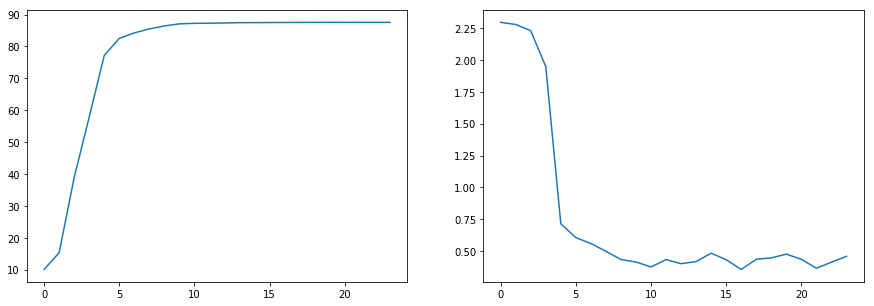

In [165]:
fig, (ax1,ax2) = plt.subplots(1,2)
fig.set_size_inches(15,5)
ax1.plot(train_accuracies)
ax1.plot(val_accuracies)

ax2.plot(train_loss_hist)
ax2.plot(val_loss_hist)

plt.show()

In [166]:
%%time
print('Accuracy on training dataset:',return_accuracy(train_loader,model))
print('Accuracy on test dataset:',return_accuracy(val_loader,model))

Accuracy on training dataset: 87.53806938559322
Accuracy on test dataset: 87.24609375
CPU times: user 10.1 s, sys: 151 ms, total: 10.2 s
Wall time: 10.2 s


In [171]:
epochs = 5
total = 60000
batch = 512
batch_num = int(total/batch)+1

print(118*512)

60416


In [175]:
int(total/2)

30000